In [1]:
import os
import clr
import sys
from imp import reload
from System import Array
from time import sleep, time
import numpy as np
from matplotlib import pyplot as plt
# sys.path.append(os.getcwd())
%matplotlib inline

import qcodes as qc
qc.show_subprocess_widget()

<IPython.core.display.Javascript object>

# ATS

In [171]:
import qcodes.instrument_drivers.AlazarTech.ATS9440 as ATS_driver
import qcodes.instrument_drivers.AlazarTech.ATS_acquisition_controllers as ATS_control
try:
    ATS.close()
    ATS_controller.close()
except:
    pass
reload(ATS_driver)
reload(ATS_control)

ATS = ATS_driver.ATS9440('ATS', server_name='Alazar_server')
ATS_controller = ATS_control.Average_AcquisitionController(name='ATS_control', 
                                                           alazar_id=0,
                                                           server_name='Alazar_server')

ATS.config(trigger_source1='CHANNEL_C',
           trigger_level1=135,
           channel_range=2,
           sample_rate=1e6,
           coupling='DC')
ATS_controller.set_acquisitionkwargs(buffer_timeout=5000,
                                     samples_per_record=48000,
                                     records_per_buffer=1,
                                     buffers_per_acquisition=2,
                                     channel_selection='AC')


In [151]:
try:
    SIM900.close()
except:
    pass
reload(SIM900_driver)
import qcodes.instrument_drivers.stanford_research.SIM900 as SIM900_driver
SIM900 = SIM900_driver.SIM900('SIM900', 'GPIB0::4::INSTR')
TG, LB, RB, TGAC, SRC, _, DS, DF = [eval('SIM900.chan{}'.format(i)) for i in range(1,9)]


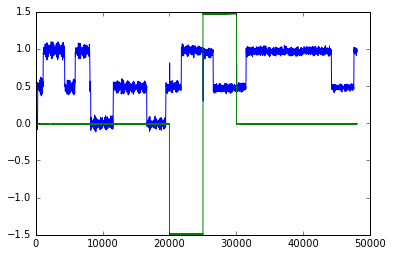

In [175]:
ATS_controller.average_mode('trace')
result = ATS_controller.do_acquisition()

plt.plot(result[0])
plt.plot(result[1])

In [157]:
t0 = time()
TGAC(1.625)
print('Time taken: {} s', time()-t0)
# TGAC()

Time taken: {} s 0.20101141929626465
